### based on https://docs.ray.io/en/latest/serve/tutorials/pytorch.html

In [1]:
import os 
import time
import requests
from io import BytesIO
from PIL import Image

import ray
from ray import serve

import torch
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage
from ray_cluster_control import start_ray_cluster, stop_ray_cluster

/opt/app-root/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@serve.deployment(route_prefix="/image_predict", name="pet_image", ray_actor_options={"num_gpus": 1})
class ImageModel:

    def __init__(self):
        self.model = torch.jit.load("ray_model_scripted.pt", 
                                    map_location=torch.device('cuda:0'))
        self.preprocessor = Compose([Resize((64,64)),
                                     ToTensor()])

    async def __call__(self, starlette_request):
        image_payload_bytes = await starlette_request.body()
        pil_image = Image.open(BytesIO(image_payload_bytes))

        pil_images = [pil_image]
        input_tensor = torch.cat([self.preprocessor(i) for i in pil_images])
        input_tensor = torch.reshape(input_tensor, (1,3,64,64))
        with torch.no_grad():
            output_tensor = self.model(input_tensor.to("cuda"))

        return int(torch.argmax(output_tensor[0]))

In [9]:
ray_cluster_name = os.getenv('RAY_CLUSTER_NAME')
#start_ray_cluster(cluster_name = ray_cluster_name)

In [3]:
workpath = os.getenv('DEMO_WORK_PATH')
ray.init(f'ray://{ray_cluster_name}-ray-head:10001',
         runtime_env={"working_dir": f"{workpath}/models/"})

2022-09-12 22:32:52,254	INFO packaging.py:414 -- Creating a file package for local directory '/opt/app-root/src/ray-on-the-edge-demo/notebooks/octo-next-2022/models/'.
2022-09-12 22:32:52,264	INFO packaging.py:258 -- Pushing file package 'gcs://_ray_pkg_481a6d0b8129db74.zip' (3.14MiB) to Ray cluster...
2022-09-12 22:32:52,343	INFO packaging.py:267 -- Successfully pushed file package 'gcs://_ray_pkg_481a6d0b8129db74.zip'.


ClientContext(dashboard_url='10.128.4.244:8265', python_version='3.8.12', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', protocol_version='2022-03-16', _num_clients=2, _context_to_restore=<ray.util.client._ClientContext object at 0x7fca720d18e0>)

In [4]:
host = ray.nodes()[0]["NodeManagerAddress"]
host

'10.128.4.244'

In [5]:
serve.start(http_options={"host":host})

Caught schedule exception
2022-09-12 22:33:13,055	INFO common.py:219 -- Exception from actor creation is ignored in destructor. To receive this exception in application code, call a method on the actor reference before its destructor is run.
(ServeController pid=4293) INFO 2022-09-12 22:33:14,491 controller 4293 checkpoint_path.py:17 - Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=4293) INFO 2022-09-12 22:33:14,595 controller 4293 http_state.py:112 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:uoXofs:SERVE_PROXY_ACTOR-node:10.128.4.244-0' on node 'node:10.128.4.244-0' listening on '10.128.4.244:8000'
(HTTPProxyActor pid=4328) INFO:     Started server process [4328]


In [6]:
ImageModel.deploy()

(ServeController pid=4293) INFO 2022-09-12 22:33:24,870 controller 4293 deployment_state.py:1216 - Adding 1 replicas to deployment 'pet_image'.


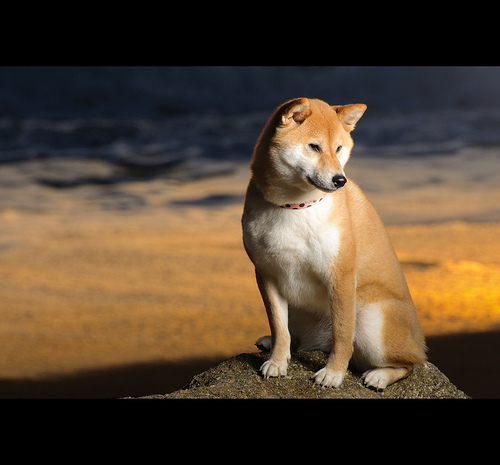

In [7]:
with open(f"{workpath}/data/oxford-iiit-pet/images/shiba_inu_9.jpg", "rb") as image:
    f = image.read()
    feature_data = bytearray(f)
Image.open(BytesIO(feature_data))

In [8]:
resp = requests.post(f"http://{host}:8000/image_predict", data=feature_data)
print(f"Predicted Class: {resp.json()}")

Predicted Class: 6


(HTTPProxyActor pid=4328) INFO 2022-09-12 22:33:54,482 http_proxy 10.128.4.244 http_proxy.py:310 - POST /image_predict 200 452.8ms
(pet_image pid=4411) INFO 2022-09-12 22:33:54,481 pet_image pet_image#wOSMUp replica.py:478 - HANDLE __call__ OK 447.7ms


In [10]:
#stop_ray_cluster(cluster_name = ray_cluster_name)